In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
import numpy as np

In [2]:
#Load Excel with each sheet as a condition
excel_path = "DESeq2_DEGs_yeast_09042025.xlsx"
sheet_dict = pd.read_excel(excel_path, sheet_name=None)

#Prepare a combined dataframe
combined = []

for condition, df in sheet_dict.items():
    df = df[['Systematic Name', 'log2FoldChange']].copy()
    df.dropna(subset=['log2FoldChange'], inplace=True)
    df['condition'] = condition
    combined.append(df)

all_degs = pd.concat(combined)
all_degs.head()

,Systematic Name,log2FoldChange,condition
0,YBR116C,6.810618,rpd3KO_DEGs
1,YHR079C-A,6.742978,rpd3KO_DEGs
2,YJR095W,6.735313,rpd3KO_DEGs
3,YLR445W,6.698115,rpd3KO_DEGs
4,YBL065W,6.345972,rpd3KO_DEGs


In [3]:
unique_degs = all_degs['Systematic Name'].nunique()
print(f"Total unique DEGs across all conditions: {unique_degs}")

Total unique DEGs across all conditions: 1795


In [4]:
#Step 1: Get gene matrix
wide_df = all_degs.pivot_table(index='Systematic Name', columns='condition', values='log2FoldChange')

#Step 2: Get sets of DEGs per condition
ume6_set = set(wide_df[~wide_df['Ume6KO_DEGs'].isna()].index)
e6r_set = set(wide_df[~wide_df['E6R_DEGs'].isna()].index)

#Step 3: Get all other condition columns
all_conditions = set(wide_df.columns)
other_conditions = all_conditions - {'Ume6KO_DEGs', 'E6R_DEGs'}

#Genes expressed in other conditions
other_set = set()
for cond in other_conditions:
    other_set |= set(wide_df[~wide_df[cond].isna()].index)

#Step 4: Compute categories

#Shared between Ume6KO & E6R only (not in others)
ume6_e6r_only = ume6_set & e6r_set - other_set

#Shared between Ume6KO, E6R, and ≥1 other condition
ume6_e6r_shared_with_others = ume6_set & e6r_set & other_set

#Exclusive to Ume6KO
ume6_only = ume6_set - (e6r_set | other_set)

#Exclusive to E6R
e6r_only = e6r_set - (ume6_set | other_set)

print(f"🔴 Shared only Ume6KO & E6R: {len(ume6_e6r_only)}")
print(f"🟠 Shared with Ume6KO, E6R + ≥1 other: {len(ume6_e6r_shared_with_others)}")
print(f"🔵 Ume6KO-specific only: {len(ume6_only)}")
print(f"🟣 E6R-specific only: {len(e6r_only)}")

🔴 Shared only Ume6KO & E6R: 78
🟠 Shared with Ume6KO, E6R + ≥1 other: 119
🔵 Ume6KO-specific only: 537
🟣 E6R-specific only: 131


In [5]:
#For dotplots or heatmaps
ume6_e6r_only_df = all_degs[all_degs['Systematic Name'].isin(ume6_e6r_only)]
ume6_e6r_shared_df = all_degs[all_degs['Systematic Name'].isin(ume6_e6r_shared_with_others)]
ume6_only_df = all_degs[all_degs['Systematic Name'].isin(ume6_only)]
e6r_only_df = all_degs[all_degs['Systematic Name'].isin(e6r_only)]

In [6]:
#Filter for Ume6KO log2FC to classify direction
ume6_logfc = ume6_e6r_only_df[ume6_e6r_only_df['condition'] == 'Ume6KO_DEGs']

#Split up/down DEG sets 
ume6_up = ume6_logfc[ume6_logfc['log2FoldChange'] > 0]
ume6_down = ume6_logfc[ume6_logfc['log2FoldChange'] < 0]

print(f"🔺 Ume6KO-E6R Only: Upregulated = {len(ume6_up)}, Downregulated = {len(ume6_down)}")

#Top 25 by absolute log2FC
top25_ume6 = ume6_logfc.copy()
top25_ume6['abs_log2FC'] = top25_ume6['log2FoldChange'].abs()
top25_genes = top25_ume6.sort_values(by='abs_log2FC', ascending=False).head(25)['Systematic Name'].tolist()

#Subset full dataframe for those 25 genes across conditions
ume6_e6r_top25_df = ume6_e6r_only_df[ume6_e6r_only_df['Systematic Name'].isin(top25_genes)]
ume6_e6r_top25_df.head(5)

🔺 Ume6KO-E6R Only: Upregulated = 62, Downregulated = 16


,Systematic Name,log2FoldChange,condition
12,YML089C,7.636407,Ume6KO_DEGs
52,YAR035W,4.696819,Ume6KO_DEGs
64,YOR391C,4.247254,Ume6KO_DEGs
66,YPR145C-A,4.210657,Ume6KO_DEGs
109,YEL049W,3.312991,Ume6KO_DEGs


In [7]:
#Extract DEGs shared in all 5 conditions (later minus the specific DEGs in Ume6KO & E6R):

#Define all five condition sets
ume6_set = set(wide_df[~wide_df['Ume6KO_DEGs'].isna()].index)
e6r_set = set(wide_df[~wide_df['E6R_DEGs'].isna()].index)
tsa_set = set(wide_df[~wide_df['TSA_DEGs'].isna()].index)
sin3_set = set(wide_df[~wide_df['Sin3KO_DEGs'].isna()].index)
rpd3_set = set(wide_df[~wide_df['rpd3KO_DEGs'].isna()].index)

#Shared across all five
shared_across_all_conditions = ume6_set & e6r_set & tsa_set & sin3_set & rpd3_set

print(f"Genes DE in all 5 conditions: {len(shared_across_all_conditions)}")

Genes DE in all 5 conditions: 58


In [8]:
#Read file again to grab the adjusted p-vals: 
excel_path = "DESeq2_DEGs_yeast_09042025.xlsx"

# === Step 1: Read & combine all sheets ===

#Read all sheets
sheet_dict = pd.read_excel(excel_path, sheet_name=None)

#Combine all conditions into one dataframe
combined = []

for condition, df in sheet_dict.items():
    df = df[['Systematic Name', 'log2FoldChange', 'padj']].copy()
    df.dropna(subset=['log2FoldChange'], inplace=True)
    df['condition'] = condition
    combined.append(df)

all_degs = pd.concat(combined, ignore_index=True)
all_degs.head()

,Systematic Name,log2FoldChange,padj,condition
0,YBR116C,6.810618,6.350000e-08,rpd3KO_DEGs
1,YHR079C-A,6.742978,3.870000e-10,rpd3KO_DEGs
2,YJR095W,6.735313,9.490000e-08,rpd3KO_DEGs
3,YLR445W,6.698115,1.150000e-07,rpd3KO_DEGs
4,YBL065W,6.345972,6.710000e-07,rpd3KO_DEGs


In [9]:
shared_all_conditions_df = all_degs[
    (all_degs['Systematic Name'].isin(shared_across_all_conditions)) &
    (all_degs['condition'].isin(['Ume6KO_DEGs', 'E6R_DEGs', 'TSA_DEGs', 'Sin3KO_DEGs', 'rpd3KO_DEGs']))
].copy()

#Add -log10(padj) for bubble size
shared_all_conditions_df['neg_log10_padj'] = -np.log10(shared_all_conditions_df['padj'].replace(0, np.nextafter(0, 1)))


In [10]:
#Subtract ume6_e6r_only genes from the shared set to prevent redundancy: 
non_redundant_shared_genes = (
    ume6_set & e6r_set & tsa_set & sin3_set & rpd3_set
) - ume6_e6r_only

print(f"🟣 Final non-redundant shared DEGs across all 5 conditions: {len(non_redundant_shared_genes)}")


🟣 Final non-redundant shared DEGs across all 5 conditions: 58


In [11]:
shared_all_conditions_df = all_degs[
    (all_degs['Systematic Name'].isin(non_redundant_shared_genes)) &
    (all_degs['condition'].isin(['Ume6KO_DEGs', 'E6R_DEGs', 'TSA_DEGs', 'Sin3KO_DEGs', 'rpd3KO_DEGs']))
].copy()

#Clean p-values & compute -log10 for size
shared_all_conditions_df['padj'] = pd.to_numeric(shared_all_conditions_df['padj'], errors='coerce')
shared_all_conditions_df['padj'] = shared_all_conditions_df['padj'].replace(0, np.nextafter(0, 1))
shared_all_conditions_df['neg_log10_padj'] = -np.log10(shared_all_conditions_df['padj'])

shared_all_conditions_df

,Systematic Name,log2FoldChange,padj,condition,neg_log10_padj
0,YBR116C,6.810618,6.350000e-08,rpd3KO_DEGs,7.197226
4,YBL065W,6.345972,6.710000e-07,rpd3KO_DEGs,6.173277
7,YOL131W,5.842577,3.840000e-14,rpd3KO_DEGs,13.415669
16,YDR014W-A,4.975363,4.230000e-30,rpd3KO_DEGs,29.373660
18,YEL021W,4.350039,3.680000e-22,rpd3KO_DEGs,21.434152
...,...,...,...,...,...
3284,YHL044W,1.030820,2.770000e-07,E6R_DEGs,6.557520
3296,YMR085W,1.007198,2.680000e-08,E6R_DEGs,7.571865
3315,YOL104C,-1.036373,1.980000e-05,E6R_DEGs,4.703335
3395,YER011W,-1.542506,6.230000e-17,E6R_DEGs,16.205512


In [12]:
filtered_df_shared= shared_all_conditions_df.copy() 

In [13]:
shared_all_conditions_df.to_csv("FigureS5B_Genes_to_plot.csv")

In [14]:
#Map the yeast Systematic Names to Gene symbols (except cases where converted_alias=None)
#Mapping was done using g:Profiler (Systematic names > Gene symbols) 

#1. Load the mapping file, skipping the first 3 rows (header rows)
mapping_df = pd.read_csv("figS5B_gProfiler_gene_mappings.csv", header=0, skiprows=[1,2])

#Check the columns to confirm
print(mapping_df.columns.tolist())  #Should show ['initial_alias', 'converted_alias'

#2. Create a dictionary for mapping systematic names to gene symbols
mapping_dict = {}

for idx, row in mapping_df.iterrows():
    sys_name = row['initial_alias']
    gene_symbol = row['converted_alias']
    #If converted_alias is None or 'None', keep the initial_alias
    if pd.isna(gene_symbol) or gene_symbol == 'None':
        mapping_dict[sys_name] = sys_name
    else:
        mapping_dict[sys_name] = gene_symbol

#3. Add a new column to filtered_df_shared with the gene symbols
filtered_df_shared['Gene_Symbol'] = filtered_df_shared['Systematic Name'].map(mapping_dict)

#4. Display the updated dataframe
print(filtered_df_shared.head())


['initial_alias', 'converted_alias', 'name', 'description', 'namespace']
   Systematic Name  log2FoldChange          padj    condition  neg_log10_padj  \
0          YBR116C        6.810618  6.350000e-08  rpd3KO_DEGs        7.197226   
4          YBL065W        6.345972  6.710000e-07  rpd3KO_DEGs        6.173277   
7          YOL131W        5.842577  3.840000e-14  rpd3KO_DEGs       13.415669   
16       YDR014W-A        4.975363  4.230000e-30  rpd3KO_DEGs       29.373660   
18         YEL021W        4.350039  3.680000e-22  rpd3KO_DEGs       21.434152   

   Gene_Symbol  
0      YBR116C  
4      YBL065W  
7      YOL131W  
16        HED1  
18        URA3  


In [15]:
from matplotlib import cm, colors, font_manager

In [16]:
# ========== Assign Arial font paths ==========
FONT_PATHS = {
    'regular': "/usr/share/fonts/truetype/msttcorefonts/Arial.ttf",
    'bold': "/usr/share/fonts/truetype/msttcorefonts/Arial_Bold.ttf"
}
arial_font = font_manager.FontProperties(fname=FONT_PATHS['regular'])
arial_bold = font_manager.FontProperties(fname=FONT_PATHS['bold'])


# ========== Define conditions for x-axis ==========
condition_order = ['Ume6KO_DEGs', 'E6R_DEGs', 'TSA_DEGs', 'Sin3KO_DEGs', 'rpd3KO_DEGs']

filtered_df_shared['condition'] = pd.Categorical(
    filtered_df_shared['condition'],
    categories=condition_order,
    ordered=True
)

# ========== Map conditions to x-axis coordinates ==========
x_mapping = {cond: i for i, cond in enumerate(condition_order)}
x = filtered_df_shared['condition'].map(x_mapping)

# ========== Size scaling for -log10(adj. p) ==========
min_neg_log10_padj = filtered_df_shared['neg_log10_padj'].min()
max_neg_log10_padj = filtered_df_shared['neg_log10_padj'].max()
desired_min_size = 30
desired_max_size = 300
scaling_factor = (desired_max_size - desired_min_size) / (max_neg_log10_padj - min_neg_log10_padj)

s = desired_min_size + (filtered_df_shared['neg_log10_padj'] - min_neg_log10_padj) * scaling_factor

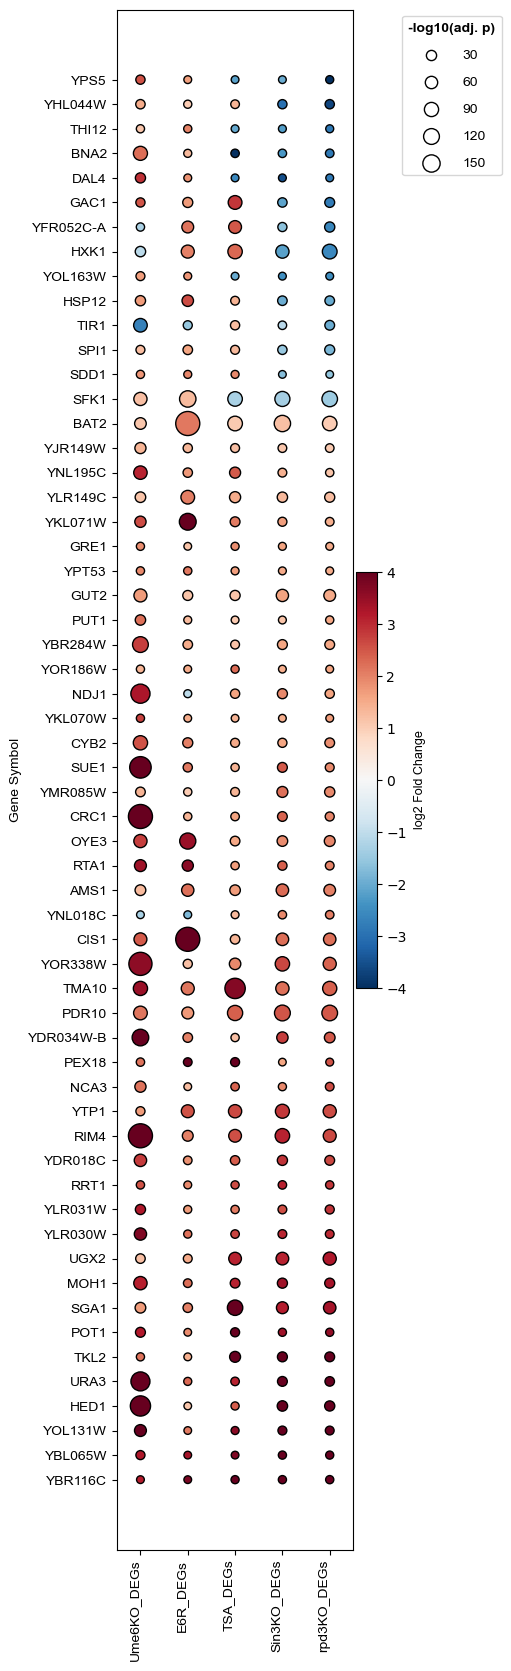

In [17]:
#Define color normalization & color map 
cmap = cm.RdBu_r
norm = colors.Normalize(vmin=-4, vmax=4)

#========== Start plotting ==========
plt.figure(figsize=(4, 20))
ax = plt.gca()

scatter = ax.scatter(
    x,
    filtered_df_shared['Gene_Symbol'],
    s=s,
    c=filtered_df_shared['log2FoldChange'],
    cmap=cmap,
    norm=norm,
    edgecolors='black'
)

#========== Assign colorbar for log2FC ==========
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.01, fraction=0.08, aspect=20)
cbar.set_label("log2 Fold Change", fontsize=9, labelpad=5, fontproperties=arial_font)

#========== Customize legends for dot size ==========
size_values = [30, 60, 90, 120, 150]
size_labels = ['30', '60', '90', '120', '150']
size_handles = [
    plt.scatter([], [], s=desired_min_size + (val - min_neg_log10_padj) * scaling_factor,
                color='white', edgecolor='black')
    for val in size_values
]

legend = ax.legend(
    size_handles,
    size_labels,
    title='-log10(adj. p)',
    loc='upper left',
    bbox_to_anchor=(1.18, 1.0),  #Increased horizontal offset
    frameon=True,
    fontsize=9,
    title_fontsize=12,
    borderpad=0.5,
    handletextpad=1.5,
    labelspacing=1.2
)

legend.set_title('-log10(adj. p)', prop=arial_bold)
for text in legend.get_texts():
    text.set_fontproperties(arial_font)

#========== Format axes ==========
ax.set_xticks(range(len(condition_order)))
ax.set_xticklabels(condition_order, rotation=90, ha='right', fontsize=9, fontproperties=arial_font)
ax.set_xlim(-0.5, len(condition_order) - 0.5)
ax.set_xlabel("", fontproperties=arial_font)
ax.set_ylabel("Gene Symbol", fontsize=10, fontproperties=arial_font)
plt.yticks(fontsize=22, fontproperties=arial_font)
#plt.title("Conserved DEGs Across All Conditions", fontsize=11, fontproperties=arial_bold)

#========== Important adjustments ==========
plt.subplots_adjust(left=0.25, right= 0.9)  #Compress horizontal space
plt.savefig(
    "Shared_DEGs_All_Conditions_Dotplot_Final_v2_13052025.pdf",
    dpi=300,
    bbox_inches='tight',
    bbox_extra_artists=[legend],  #Explicitly include legend in bbox calc
    pad_inches=0  #Minimal padding
)
plt.show()
